# Тест детектора YOLO на COCO датасете

1.  Download YOLO-11 from [Ultralytics.com](https://docs.ultralytics.com/models/yolo11/) , use the faster [model](https://docs.ultralytics.com/tasks/detect/#models).
2. Check model on arbitrary image.
3. Install [pycocotools](https://github.com/cocodataset/cocoapi.git)
5. Load first five images with bicycles from COCO dataset
6. Perform object detection only for bycycle class using YOLO.
7. Display ground true and detected bounding boxes on images. Use red color for YOLO bounding boxes and green for ground true.


In [ ]:
!pip install ultralytics

In [ ]:
!pip install pycocotools

In [ ]:
!pip install torchmetrics

In [3]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##  Download YOLO


Create model instance. [models](https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS.md)

In [4]:
from ultralytics import YOLO

yolo = YOLO("yolo11x.pt").to(device)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 109M/109M [00:00<00:00, 131MB/s]


## Smoke test

Test model on arbitrary image

In [6]:
from PIL import Image

! wget -qO cat.png https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX11/semantic_segmentation.png

img = Image.open("/content/cat.png")

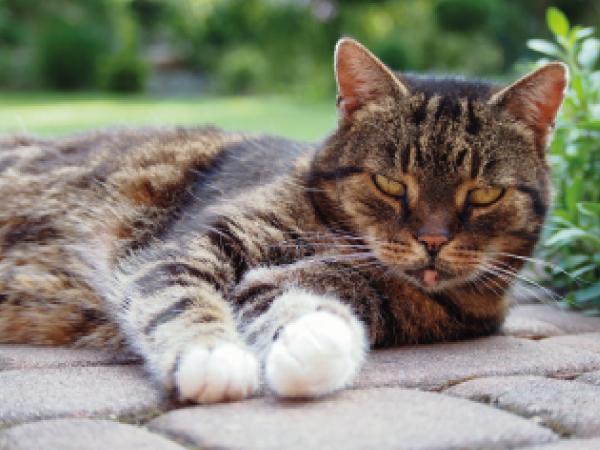

In [7]:
display(img)

In [8]:
result = yolo.predict(img)


0: 480x640 1 cat, 2856.8ms
Speed: 40.3ms preprocess, 2856.8ms inference, 32.2ms postprocess per image at shape (1, 3, 480, 640)


## Load the data

Load first five images with bicycles from COCO dataset

*  Use [pycocotools](https://github.com/cocodataset/cocoapi.git)
*  Display loaded images

reference: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [10]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

--2025-02-13 16:47:45--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.206.121, 52.217.133.73, 54.231.192.57, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.206.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  42.4MB/s    in 6.3s    

2025-02-13 16:47:51 (38.4 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [17]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip

--2025-02-13 17:02:45--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.239, 54.231.204.49, 52.217.197.121, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip.1’

val2017.zip.1       100%[===================>] 777.80M  45.8MB/s    in 17s     

2025-02-13 17:03:02 (44.5 MB/s) - ‘val2017.zip.1’ saved [815585330/815585330]

Archive:  val2017.zip
replace val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


val архив меньше по времени скачивается

In [20]:
from pycocotools.coco import COCO

ann_file = 'annotations/instances_val2017.json'
coco = COCO(ann_file)

cat_ids = coco.getCatIds(catNms=['bicycle'])                                      # category IDs for bicycles
img_ids = coco.getImgIds(catIds=cat_ids)[:5]                                      # first five images with bicycles


loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


In [30]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision(iou_type="bbox").to(device)                         # create mAP metric

## Detection

Detect bicycles in downloaded images using YOLO.

Display ground true and detected bounding boxes on images. Use red for YOLO bounding boxes and green for ground true.

https://pytorch.org/vision/stable/utils.html

The resulting images should look as follows:

 <img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX11/result_4_task_ex11.png" width="400">


In [26]:
import matplotlib.patches as patches                                              # for drawing bounding boxes on plots

def draw_boxes(ax, boxes, color='r', label='', linewidth=2, coeff=1):
    for box in boxes:
        x1, y1, x2, y2 = box

        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=linewidth,
            edgecolor=color,
            facecolor='none'
        )

        if label:
            text_x = x1
            text_y = y1 - 10 * coeff

            ax.text(
                text_x, text_y,
                label,
                fontsize=8,
                color='white',
                bbox=dict(facecolor=color, alpha=0.5),
            )

        ax.add_patch(rect)



image 1/1 /content/val2017/000000184324.jpg: 448x640 5 bicycles, 2949.7ms
Speed: 2.8ms preprocess, 2949.7ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


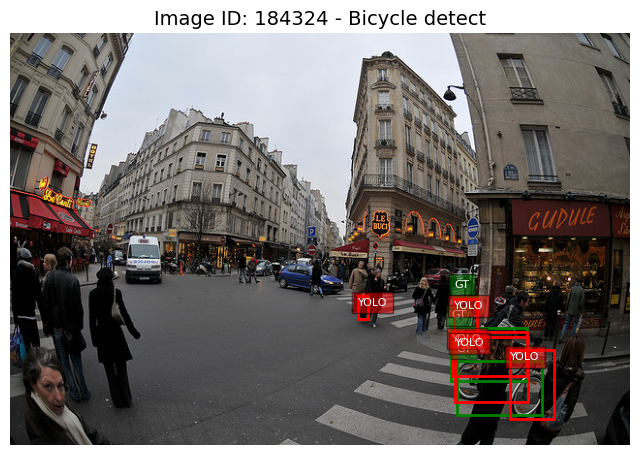


image 1/1 /content/val2017/000000546823.jpg: 480x640 (no detections), 4546.7ms
Speed: 7.4ms preprocess, 4546.7ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


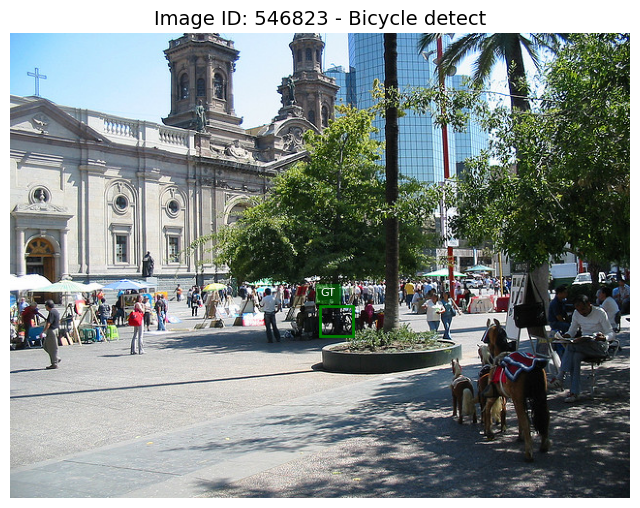


image 1/1 /content/val2017/000000343561.jpg: 448x640 11 bicycles, 4150.5ms
Speed: 3.6ms preprocess, 4150.5ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


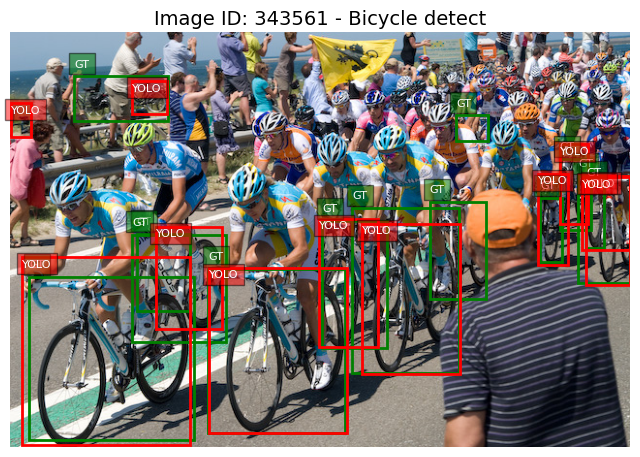


image 1/1 /content/val2017/000000169996.jpg: 480x640 2 bicycles, 3247.4ms
Speed: 3.2ms preprocess, 3247.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


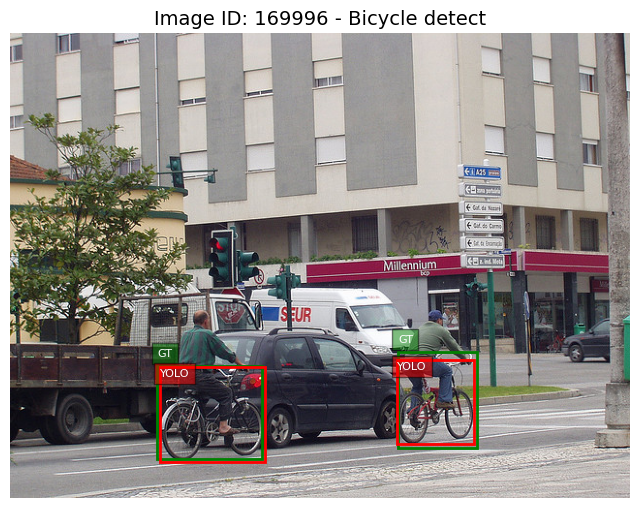


image 1/1 /content/val2017/000000277005.jpg: 448x640 1 bicycle, 2513.1ms
Speed: 3.0ms preprocess, 2513.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


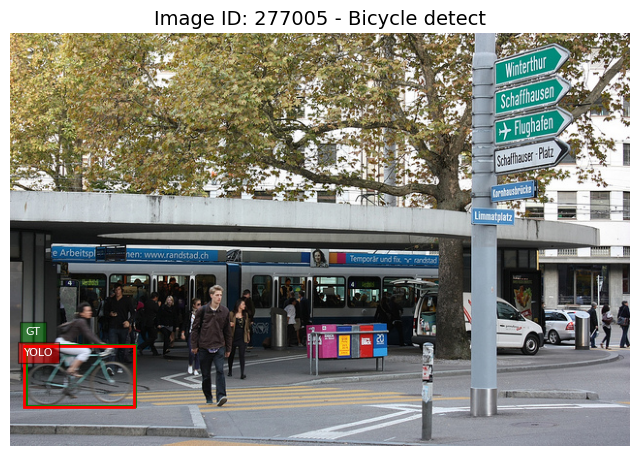

In [31]:
import matplotlib.pyplot as plt

for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"val2017/{img_info['file_name']}"
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    results = yolo.predict(source=img_path, classes=[1], device=device)           # predict only bicycle
    yolo_boxes = results[0].boxes.xyxy.to(device).numpy().tolist()
    gt_boxes = []
    gt_labels = []

    for ann in anns:
        x, y, w, h = ann['bbox']
        x1, y1, x2, y2 = x, y, x + w, y + h
        gt_boxes.append([x1, y1, x2, y2])
        gt_labels.append(1)                                                       # in COCO 'bicycle' class label = 1

    target = [{
        'boxes': torch.tensor(gt_boxes, dtype=torch.float32, device=device),      # convert to tensor
        'labels': torch.tensor(gt_labels, dtype=torch.int64, device=device)       # int64 for class IDs
    }]

    preds = [{
        'boxes': results[0].boxes.xyxy.to(device),
        'scores': results[0].boxes.conf.to(device),
        'labels': results[0].boxes.cls.to(device).to(torch.int64)
    }]

    metric.update(preds, target)                                                  # update metric

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    img_data = plt.imread(img_path)
    ax.imshow(img_data)

    draw_boxes(ax, gt_boxes, color='g', label='GT', linewidth=2, coeff=1)         # ground true in green
    draw_boxes(ax, yolo_boxes, color='r', label='YOLO', linewidth=2, coeff=-1)    # YOLO in red

    ax.set_title(f"Image ID: {img_id} - Bicycle detect", fontsize=14)
    plt.axis('off')
    plt.show()


## Ideas for extra work


* Calculate mAP metric for bicycle detection. You can use [cocoEval.evaluate](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py) or [Torchmetrics](https://torchmetrics.readthedocs.io/en/stable/).
* Use open vocabulary free detector like [OWLv2](https://huggingface.co/docs/transformers/model_doc/owlv2) and compare it mAP with YOLO's

In [35]:
def format_map_results(results_dict):
    formatted = {}

    for k, v in results_dict.items():
        if isinstance(v, torch.Tensor):
            if v.dtype in (torch.int32, torch.int64):
                formatted[k] = int(v.item())
            else:
                formatted[k] = float(v.item())
        else:
            formatted[k] = v

    return formatted

In [37]:
import json

result = metric.compute()                                                         # calculate final mAP

print(json.dumps(format_map_results(result), indent=4))                           # print readable json

{
    "map": 0.39594388008117676,
    "map_50": 0.623619556427002,
    "map_75": 0.500450074672699,
    "map_small": 0.4039604067802429,
    "map_medium": 0.2951732575893402,
    "map_large": 0.657095730304718,
    "mar_1": 0.16500000655651093,
    "mar_10": 0.42500001192092896,
    "mar_100": 0.42500001192092896,
    "mar_small": 0.4000000059604645,
    "mar_medium": 0.32307693362236023,
    "mar_large": 0.699999988079071,
    "map_per_class": -1.0,
    "mar_100_per_class": -1.0,
    "classes": 1
}


1. модель показывает неплохую точность для крупного велосипеда, но с мелкими (mAP=0.40 и 0.29) справляется хуже

2. разница между map_50 и map_75 показывает, что при более точных требованиях к IoU часть предсказаний ощутимо смещена от реального объекта

3. общая mAP=0.396 на 5 изображениях не особо представительная

In [38]:
n = coco.getImgIds(catIds=cat_ids)

for img_id in n:
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"val2017/{img_info['file_name']}"
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    results = yolo.predict(source=img_path, classes=[1], device=device)
    gt_boxes = []
    gt_labels = []

    for ann in anns:
        x, y, w, h = ann['bbox']
        x1, y1, x2, y2 = x, y, x + w, y + h
        gt_boxes.append([x1, y1, x2, y2])
        gt_labels.append(1)

    target = [{
        'boxes': torch.tensor(gt_boxes, dtype=torch.float32, device=device),
        'labels': torch.tensor(gt_labels, dtype=torch.int64, device=device)
    }]

    preds = [{
        'boxes': results[0].boxes.xyxy.to(device),
        'scores': results[0].boxes.conf.to(device),
        'labels': results[0].boxes.cls.to(device).to(torch.int64)
    }]

    metric.update(preds, target)



image 1/1 /content/val2017/000000184324.jpg: 448x640 5 bicycles, 2430.3ms
Speed: 4.5ms preprocess, 2430.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/val2017/000000546823.jpg: 480x640 (no detections), 2552.4ms
Speed: 2.2ms preprocess, 2552.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/val2017/000000343561.jpg: 448x640 11 bicycles, 2369.1ms
Speed: 2.8ms preprocess, 2369.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/val2017/000000169996.jpg: 480x640 2 bicycles, 3693.3ms
Speed: 2.2ms preprocess, 3693.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/val2017/000000277005.jpg: 448x640 1 bicycle, 4212.2ms
Speed: 3.4ms preprocess, 4212.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/val2017/000000549390.jpg: 448x640 6 bicycles, 4143.4ms
Speed: 3.0ms preprocess, 4143.4ms inference, 2.2ms

In [39]:
result = metric.compute()

print(json.dumps(format_map_results(result), indent=4))

{
    "map": 0.4014277458190918,
    "map_50": 0.6027008891105652,
    "map_75": 0.4375908374786377,
    "map_small": 0.14847835898399353,
    "map_medium": 0.38802066445350647,
    "map_large": 0.6417837738990784,
    "mar_1": 0.2961309552192688,
    "mar_10": 0.4541666805744171,
    "mar_100": 0.4541666805744171,
    "mar_small": 0.18333333730697632,
    "mar_medium": 0.45862069725990295,
    "mar_large": 0.6900990009307861,
    "map_per_class": -1.0,
    "mar_100_per_class": -1.0,
    "classes": 1
}


общая mAP=0.401 на 149 не то, что бы лучше, хотя такая mAP вполне ожидаема для модели без дообучения